# Step 0 - Import Necessary Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Step 1- Load the files and Explore the data

In [7]:
df = pd.read_csv('Telco_Customer_Churn.csv')

In [9]:
print("Shape:", df.shape)
print(df.head())
print(df["Churn"].value_counts(dropna=False))

Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

In [11]:
# Convert TotalCharges to numeric; it often contains blanks
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [13]:
# Drop duplicates by customerID if any
df = df.drop_duplicates(subset=["customerID"])

In [15]:
# Target encode: Yes -> 1, No -> 0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [17]:
# Basic missingness check
missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing fraction (top):\n", missing.head(10))


Missing fraction (top):
 TotalCharges        0.001562
customerID          0.000000
DeviceProtection    0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
dtype: float64


In [19]:
# Optional feature engineering examples
# Avoid divide-by-zero: tenure can be 0
df["AvgChargesPerMonth"] = df["TotalCharges"] / df["tenure"].replace(0, 1)

In [21]:
# Drop ID
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"].astype(int)

# Preliminary Visualization Analysis

# Target Imbalance Bar Plot of Churn Counts

C:\Users\12146\AppData\Local\Temp\ipykernel_59076\3284787271.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No (0)", "Yes (1)"])


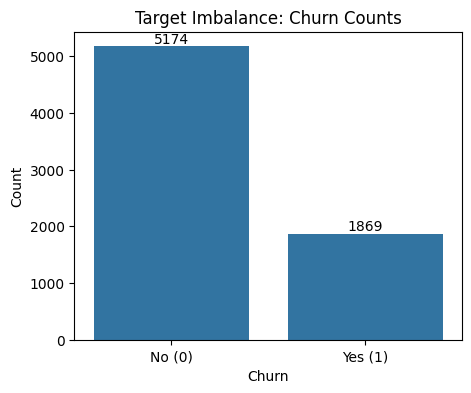

In [25]:
plt.figure(figsize=(5, 4))
ax = sns.countplot(x="Churn", data=df)
ax.set_xticklabels(["No (0)", "Yes (1)"])
ax.set_title("Target Imbalance: Churn Counts")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# Percentage of Overall Churn rate

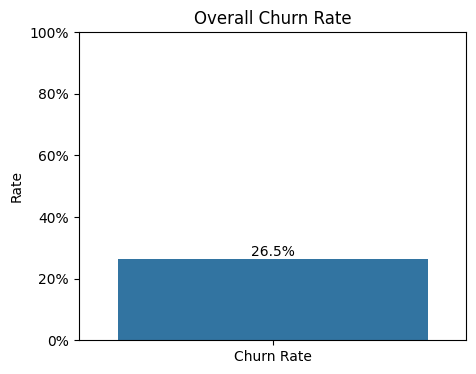

In [29]:
plt.figure(figsize=(5, 4))
rate = df["Churn"].mean()
ax = sns.barplot(x=["Churn Rate"], y=[rate])
ax.set_ylim(0, 1)
ax.set_title("Overall Churn Rate")
ax.set_ylabel("Rate")
ax.set_xlabel("")
ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
ax.bar_label(ax.containers[0], labels=[f"{rate:.1%}"])
plt.show()

In [31]:
%matplotlib inline

sns.set_style("whitegrid")

def plot_churn_rate_by_service(df, service_col):
    tbl = (
        df.groupby(service_col)["Churn"]
          .mean()
          .sort_values(ascending=False)
          .reset_index()
    )

    print(tbl)  # sanity check

    plt.figure(figsize=(7, 4))
    ax = sns.barplot(data=tbl, x=service_col, y="Churn")
    ax.set_ylim(0, 1)
    ax.set_title(f"Churn Rate by {service_col}")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.1%}",
            (p.get_x() + p.get_width()/2., p.get_height()),
            ha="center", va="bottom"
        )

    plt.xticks(rotation=15)
    plt.show()  # ← REQUIRED

  InternetService     Churn
0     Fiber optic  0.418928
1             DSL  0.189591
2              No  0.074050


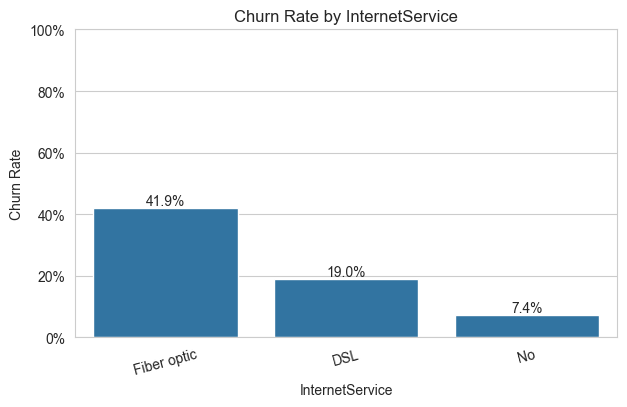

        OnlineSecurity     Churn
0                   No  0.417667
1                  Yes  0.146112
2  No internet service  0.074050


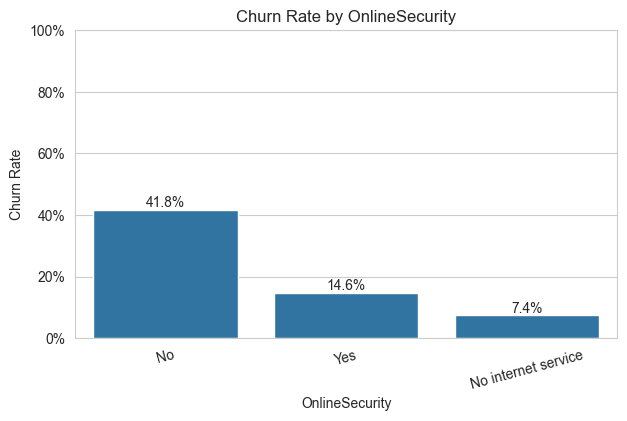

           TechSupport     Churn
0                   No  0.416355
1                  Yes  0.151663
2  No internet service  0.074050


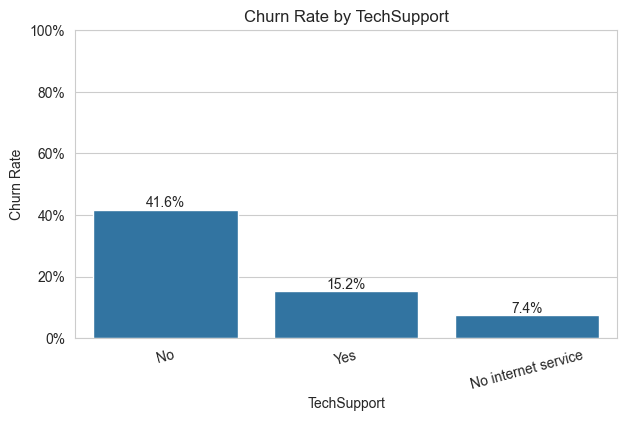

           StreamingTV     Churn
0                   No  0.335231
1                  Yes  0.300702
2  No internet service  0.074050


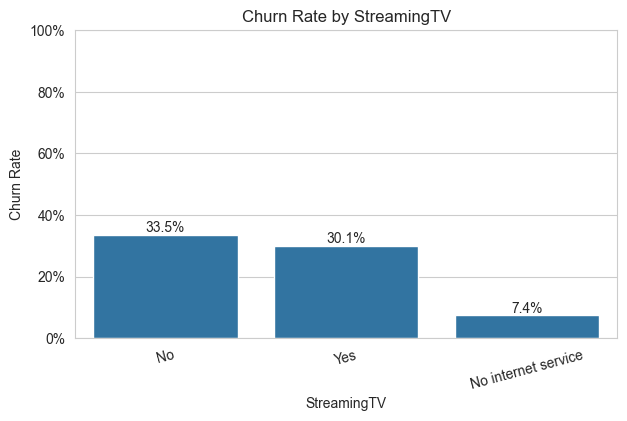

       StreamingMovies     Churn
0                   No  0.336804
1                  Yes  0.299414
2  No internet service  0.074050


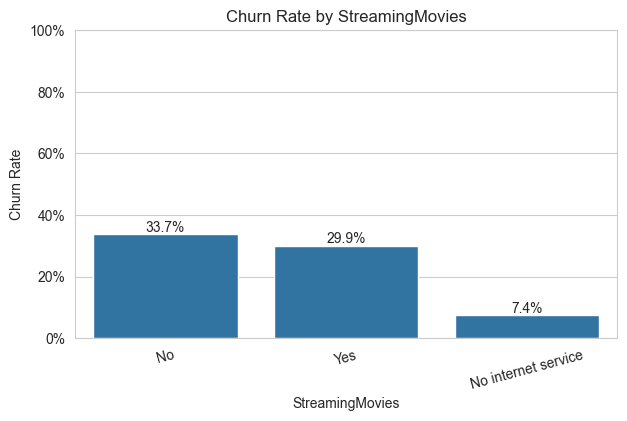

          OnlineBackup     Churn
0                   No  0.399288
1                  Yes  0.215315
2  No internet service  0.074050


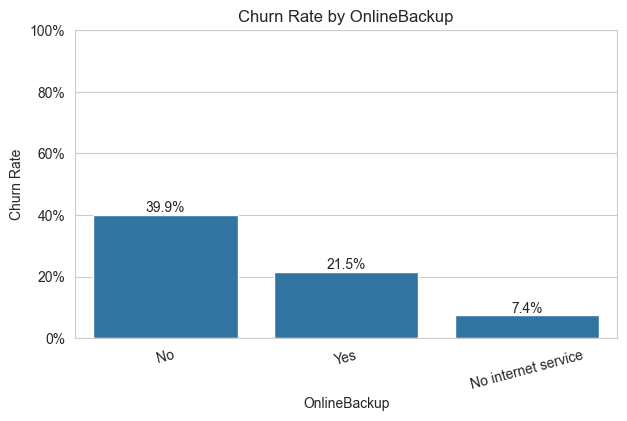

      DeviceProtection     Churn
0                   No  0.391276
1                  Yes  0.225021
2  No internet service  0.074050


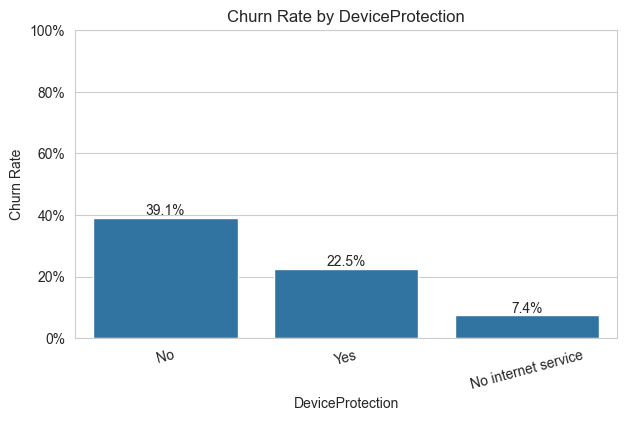

In [33]:
services = [
    "InternetService",
    "OnlineSecurity",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "OnlineBackup",
    "DeviceProtection"
]

for service in services:
    plot_churn_rate_by_service(df, service)

# Churn Rate V/S Contract Type Analysis

In [36]:
def churn_rate_table(df: pd.DataFrame, col: str, churn_col: str = "Churn") -> pd.DataFrame:
    """
    Computes count and churn rate by a categorical column.
    Assumes churn_col is binary (0/1).
    """
    tmp = df[[col, churn_col]].dropna()
    grp = tmp.groupby(col)[churn_col]
    out = pd.DataFrame({
        "count": grp.size(),
        "churn_rate": grp.mean()
    }).sort_values("churn_rate", ascending=False)
    return out 

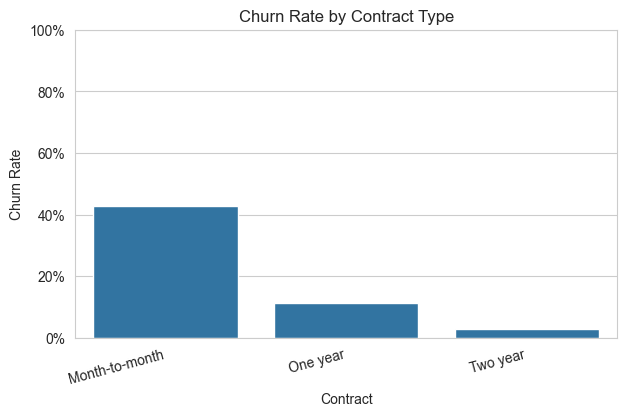

In [38]:
if "Contract" in df.columns:
    contract_tbl = churn_rate_table(df, "Contract")
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(x=contract_tbl.index, y=contract_tbl["churn_rate"].values)
    ax.set_ylim(0, 1)
    ax.set_title("Churn Rate by Contract Type")
    ax.set_xlabel("Contract")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    plt.xticks(rotation=15, ha="right")
    plt.show()

# Churn Rate V/S Tenure Bucket Analysis

C:\Users\12146\AppData\Local\Temp\ipykernel_59076\2363785564.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby(col)[churn_col]


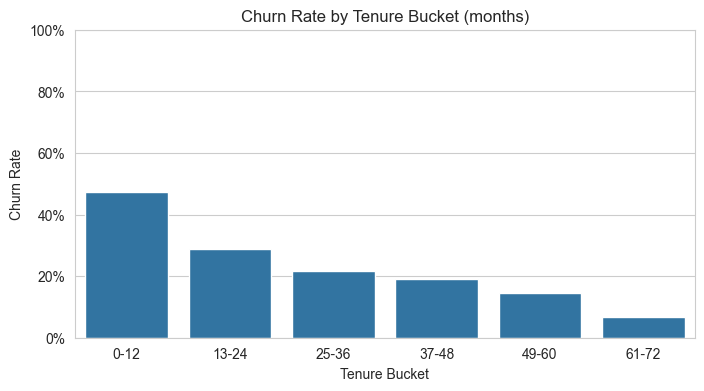

In [41]:
# Tenure buckets
# Bucket strategy (common): 0–12, 13–24, 25–36, 37–48, 49–60, 61–72
if "tenure" in df.columns:
    bins = [-0.1, 12, 24, 36, 48, 60, 72]
    labels = ["0-12", "13-24", "25-36", "37-48", "49-60", "61-72"]
    df["tenure_bucket"] = pd.cut(df["tenure"], bins=bins, labels=labels)

    tenure_tbl = churn_rate_table(df, "tenure_bucket")
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=tenure_tbl.index.astype(str), y=tenure_tbl["churn_rate"].values)
    ax.set_ylim(0, 1)
    ax.set_title("Churn Rate by Tenure Bucket (months)")
    ax.set_xlabel("Tenure Bucket")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    plt.show()

# Churn Rate V/S Payment Method Analysis

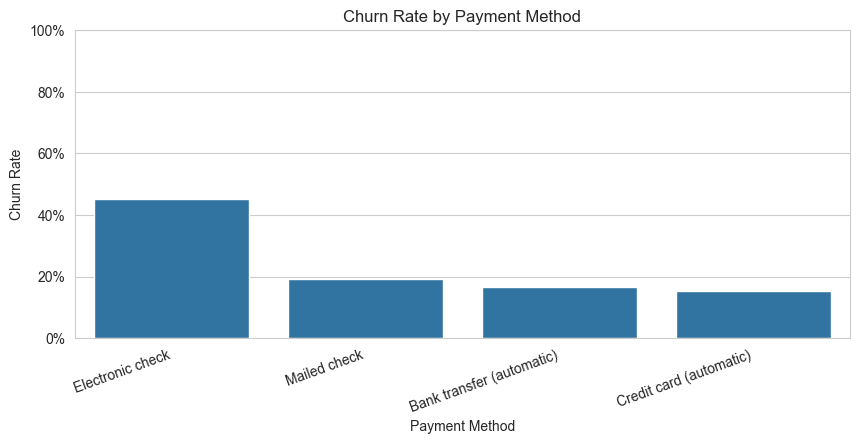

In [44]:
# Payment method
if "PaymentMethod" in df.columns:
    pay_tbl = churn_rate_table(df, "PaymentMethod")
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=pay_tbl.index, y=pay_tbl["churn_rate"].values)
    ax.set_ylim(0, 1)
    ax.set_title("Churn Rate by Payment Method")
    ax.set_xlabel("Payment Method")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    plt.xticks(rotation=20, ha="right")
    plt.show()

# Distribution of Monthly chargers: Tenure Split by Churn

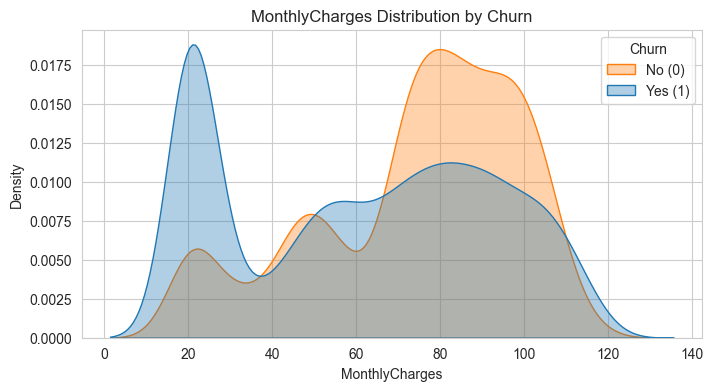

In [47]:
# 3) Distributions: MonthlyCharges, tenure split by churn
# -------------------------
# MonthlyCharges distribution split by churn
if "MonthlyCharges" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", common_norm=False, fill=True, alpha=0.35)
    plt.title("MonthlyCharges Distribution by Churn")
    plt.xlabel("MonthlyCharges")
    plt.ylabel("Density")
    plt.legend(title="Churn", labels=["No (0)", "Yes (1)"])
    plt.show()

# Tenure Distribution by Churn

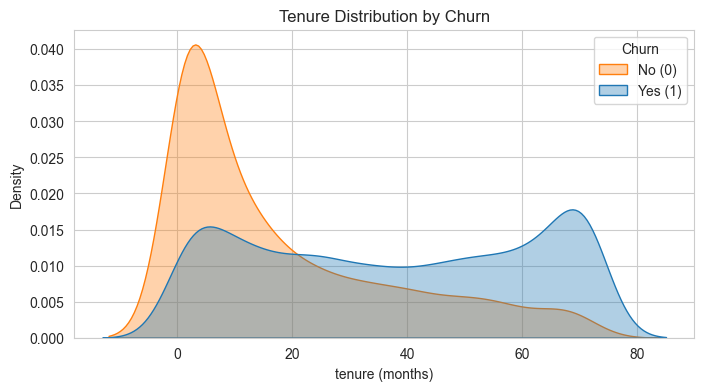

C:\Users\12146\AppData\Local\Temp\ipykernel_59076\2798956954.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No (0)", "Yes (1)"])


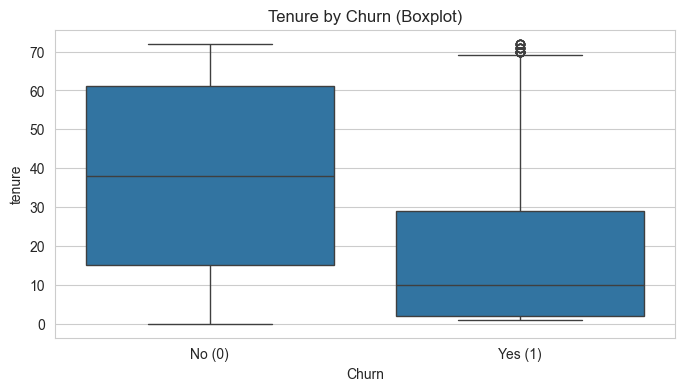

In [50]:
# Tenure distribution split by churn
if "tenure" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x="tenure", hue="Churn", common_norm=False, fill=True, alpha=0.35)
    plt.title("Tenure Distribution by Churn")
    plt.xlabel("tenure (months)")
    plt.ylabel("Density")
    plt.legend(title="Churn", labels=["No (0)", "Yes (1)"])
    plt.show()

    plt.figure(figsize=(8, 4))
    ax = sns.boxplot(data=df, x="Churn", y="tenure")
    ax.set_xticklabels(["No (0)", "Yes (1)"])
    ax.set_title("Tenure by Churn (Boxplot)")
    plt.show()

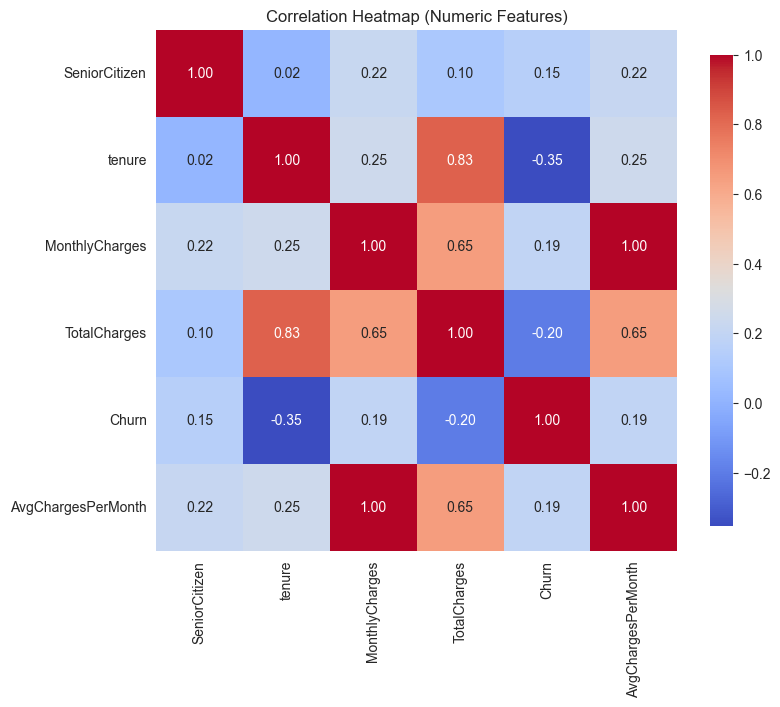


Done. Tip: set SAVE_PLOTS=True to export PNGs.


In [52]:
# Correlation Heatmap for Numeric features
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Keep it readable: typically numeric columns include: tenure, MonthlyCharges, TotalCharges, Churn
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)

    plt.figure(figsize=(6 + 0.4 * len(num_cols), 5 + 0.3 * len(num_cols)))
    ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.9})
    ax.set_title("Correlation Heatmap (Numeric Features)")
    plt.show()
else:
    print("Not enough numeric columns found for correlation heatmap.")

print("\nDone. Tip: set SAVE_PLOTS=True to export PNGs.")

##### “The correlation heatmap shows that tenure and TotalCharges are moderately to strongly negatively correlated with churn, indicating that long-term customers are less likely to leave. MonthlyCharges shows a mild positive correlation with churn. Strong correlation between tenure and TotalCharges suggests potential multicollinearity, which should be considered during model selection.”

#### Each cell = correlation coefficient (Pearson r) between two variables
#### Values range from –1 to +1
#### Value range	Meaning
#### +1.0	Perfect positive relationship
#### 0.7 to 0.9	Strong positive
#### 0.3 to 0.6	Moderate positive
#### –0.3 to –0.6	Moderate negative
#### –0.7 to –0.9	Strong negative
#### 0	No linear relationship

##### Tenure ↔ Churn = -0.35
##### 📌 Interpretation:
##### Negative → as tenure increases, churn decreases
##### Moderate strength
##### Customers who stay longer are less likely to churn
##### This aligns with business intuition ✔️

##### Feature	Correlation with Churn	Meaning
##### tenure	            Negative	           Long-term customers churn less
##### MonthlyCharges	 Mild positive	           Higher bills → more churn
##### TotalCharges	 Strong negative	       Proxy for long tenure

##### 💡 Key insight: TotalCharges and tenure are highly correlated with each other, so don’t over-interpret both independently.

# Step 3: Build Data Preprocessing Pipeline

In [59]:
# Drop ID
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"].astype(int)


In [61]:
# Identify column types
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [65]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [67]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [69]:
numeric_transformer

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [71]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [73]:
categorical_transformer

,steps,"[('imputer', ...), ('onehot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [75]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

In [77]:
preprocess 

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [79]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [81]:
# Check shapes as quick sanity check
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (5634, 21)
Test set shape: (1409, 21)


In [83]:
RANDOM_STATE = 42

# Step 4: Modeling Strategy - Using Logistic Regression, Random Forest Classifier and Gradient Boosting

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer

In [88]:
models = {
    "logreg": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(
        n_estimators=400, random_state=RANDOM_STATE,
        class_weight="balanced_subsample", n_jobs=-1
    ),
    "hgb": HistGradientBoostingClassifier(random_state=RANDOM_STATE)
}

In [90]:
models

{'logreg': LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42),
 'rf': RandomForestClassifier(class_weight='balanced_subsample', n_estimators=400,
                        n_jobs=-1, random_state=42),
 'hgb': HistGradientBoostingClassifier(random_state=42)}

In [92]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

In [94]:
def evaluate_with_cv(model):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    results = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    summary = {k: (np.mean(v), np.std(v)) for k, v in results.items() if k.startswith("test_")}
    return summary

for name, model in models.items():
    cv_summary = evaluate_with_cv(model)
    print(f"\n=== CV Results: {name} ===")
    for metric, (mean_val, std_val) in cv_summary.items():
        print(f"{metric.replace('test_', ''):>10}: {mean_val:.4f} +/- {std_val:.4f}")


=== CV Results: logreg ===
   roc_auc: 0.8455 +/- 0.0122
    pr_auc: 0.6580 +/- 0.0183
        f1: 0.6297 +/- 0.0211
 precision: 0.5192 +/- 0.0172
    recall: 0.8007 +/- 0.0341

=== CV Results: rf ===
   roc_auc: 0.8262 +/- 0.0106
    pr_auc: 0.6187 +/- 0.0279
        f1: 0.5444 +/- 0.0260
 precision: 0.6423 +/- 0.0265
    recall: 0.4729 +/- 0.0298

=== CV Results: hgb ===
   roc_auc: 0.8357 +/- 0.0082
    pr_auc: 0.6431 +/- 0.0226
        f1: 0.5717 +/- 0.0227
 precision: 0.6413 +/- 0.0284
    recall: 0.5164 +/- 0.0263


In [98]:
pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

In [100]:
pipe

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Step 5-Hyperparameter Tuning- Gradient Boosting and Random Forest Classifier

In [102]:
# Tune RandomForest
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", models["rf"])])

rf_param_dist = {
    "model__n_estimators": [300, 500, 800],
    "model__max_depth": [None, 6, 10, 14],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}

In [104]:
rf_pipe

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [106]:
rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_param_dist,
    n_iter=25,
    scoring="average_precision",   # PR-AUC focus (often better for churn imbalance)
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)
print("\nBest RF params:", rf_search.best_params_)
print("Best RF CV PR-AUC:", rf_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best RF params: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': 6}
Best RF CV PR-AUC: 0.6635398780124853


In [109]:
# Tune HistGradientBoosting
hgb_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", models["hgb"])])

hgb_param_dist = {
    "model__learning_rate": [0.03, 0.05, 0.08, 0.1],
    "model__max_depth": [None, 3, 5, 7],
    "model__max_leaf_nodes": [15, 31, 63],
    "model__min_samples_leaf": [10, 20, 30, 50],
    "model__l2_regularization": [0.0, 0.1, 1.0, 5.0]
}

In [111]:
hgb_pipe

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [113]:
hgb_search = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=hgb_param_dist,
    n_iter=25,
    scoring="average_precision",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

hgb_search.fit(X_train, y_train)
print("\nBest HGB params:", hgb_search.best_params_)
print("Best HGB CV PR-AUC:", hgb_search.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best HGB params: {'model__min_samples_leaf': 10, 'model__max_leaf_nodes': 15, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__l2_regularization': 5.0}
Best HGB CV PR-AUC: 0.6696905445197997


# Step 6: Final Evaluation on test Set

In [116]:
best_model = hgb_search if hgb_search.best_score_ >= rf_search.best_score_ else rf_search
final_pipe = best_model.best_estimator_

# Predict probabilities
y_proba = final_pipe.predict_proba(X_test)[:, 1]

# Default threshold (0.5) may not be business-optimal
default_threshold = 0.5
y_pred = (y_proba >= default_threshold).astype(int)

print("\nTest ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Test PR-AUC:", average_precision_score(y_test, y_proba))
print("\nClassification report @ 0.5 threshold:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Test ROC-AUC: 0.8460642227905654
Test PR-AUC: 0.6575524097153412

Classification report @ 0.5 threshold:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Confusion matrix:
 [[941  94]
 [179 195]]


In [118]:
final_pipe

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Visualize ROC and PR curves

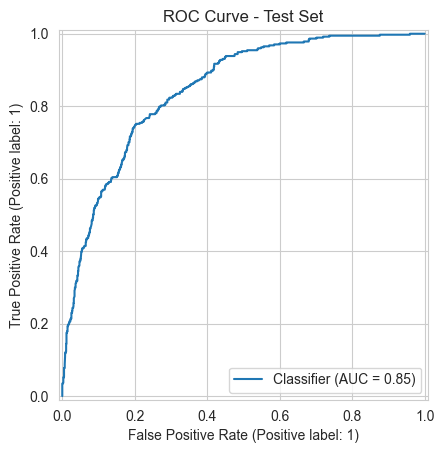

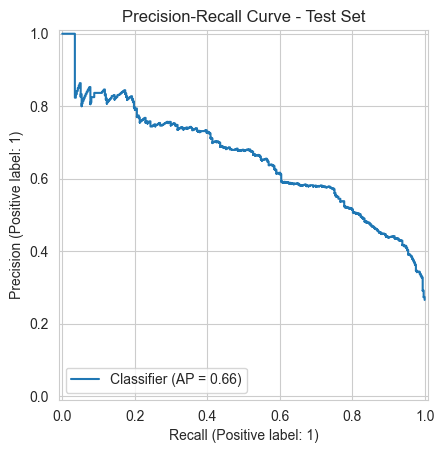

In [121]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Test Set")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title("Precision-Recall Curve - Test Set")
plt.show()


# Step 7: Business Oriented Threhsolding- Capacity Based

In [124]:
# Example: Suppose retention team can contact only top 20% highest-risk customers
capacity_pct = 0.20
cutoff = np.quantile(y_proba, 1 - capacity_pct)
y_pred_cap = (y_proba >= cutoff).astype(int)

print(f"\n--- Capacity-based thresholding: top {int(capacity_pct*100)}% ---")
print("Threshold (risk cutoff):", cutoff)
print(classification_report(y_test, y_pred_cap))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_cap))

# Capture rate: % of true churners found in contacted group
true_churners = (y_test == 1).sum()
captured_churners = ((y_test == 1) & (y_pred_cap == 1)).sum()
print(f"Captured churners: {captured_churners}/{true_churners} = {captured_churners/true_churners:.2%}")



--- Capacity-based thresholding: top 20% ---
Threshold (risk cutoff): 0.5038850844116549
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.51      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Confusion matrix:
 [[945  90]
 [182 192]]
Captured churners: 192/374 = 51.34%


# Step 8: Feature Importance - Permuation Based- Model Agnostic


Top 20 features by permutation importance (PR-AUC impact):
tenure                                     0.106738
Contract_Month-to-month                    0.096671
TechSupport_No                             0.021177
TotalCharges                               0.020098
InternetService_Fiber optic                0.015529
OnlineSecurity_No                          0.014925
MonthlyCharges                             0.003614
PaymentMethod_Electronic check             0.002352
PaperlessBilling_No                        0.002050
Contract_Two year                          0.002026
StreamingMovies_Yes                        0.001429
Contract_One year                          0.001354
AvgChargesPerMonth                         0.000732
MultipleLines_No                           0.000072
gender_Female                              0.000007
PaymentMethod_Bank transfer (automatic)    0.000007
PaymentMethod_Credit card (automatic)      0.000004
TechSupport_No internet service            0.000000
Tech

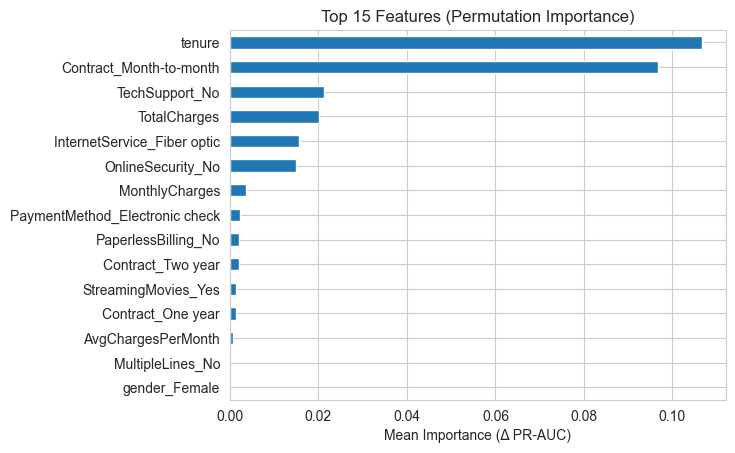

In [127]:
from sklearn.inspection import permutation_importance

# Permutation importance works on transformed features; easiest approach:
# get feature names from the preprocessor and run importance on the pipeline.

# Create feature names for one-hot
ohe = final_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_imputer = final_pipe.named_steps["preprocess"].named_transformers_["cat"].named_steps["imputer"]

# After imputation, categories are learned by OHE
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# Transform test set to numeric matrix
X_test_transformed = final_pipe.named_steps["preprocess"].transform(X_test)

# Extract model only
model_only = final_pipe.named_steps["model"]

perm = permutation_importance(
    model_only,
    X_test_transformed,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="average_precision"
)

importances = pd.Series(perm.importances_mean, index=all_feature_names).sort_values(ascending=False)
print("\nTop 20 features by permutation importance (PR-AUC impact):")
print(importances.head(20))

# Plot top features
top_n = 15
importances.head(top_n).sort_values().plot(kind="barh")
plt.title(f"Top {top_n} Features (Permutation Importance)")
plt.xlabel("Mean Importance (Δ PR-AUC)")
plt.show()


# Step 9: Scoring New Customers - Operational Use

In [130]:
# Example: score the full dataset to create a risk list
df_scores = df.copy()
df_scores["ChurnRisk"] = final_pipe.predict_proba(df_scores.drop(columns=["Churn", "customerID"]))[:, 1]
risk_list = df_scores[["customerID", "ChurnRisk", "Churn"]].sort_values("ChurnRisk", ascending=False)

print("\nTop 10 highest-risk customers:")
print(risk_list.head(10))


Top 10 highest-risk customers:
      customerID  ChurnRisk  Churn
2208  7216-EWTRS   0.888892      1
6482  5419-JPRRN   0.886324      1
3380  5178-LMXOP   0.879025      1
6866  0295-PPHDO   0.874949      1
2577  4910-GMJOT   0.873626      1
1704  0107-YHINA   0.871980      1
4800  9300-AGZNL   0.868714      1
1976  9497-QCMMS   0.868714      1
1600  3068-OMWZA   0.864416      1
2745  4826-XTSOH   0.864416      1
